# Data Loading for testing

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
!pip install python-dateutil
from datetime import datetime
from dateutil.relativedelta import relativedelta
import numpy as np
import pandas as pd
import plotly.graph_objects as go

In [5]:
symbol = 'TSLA' #change name to see data for different stock
start_date = (datetime.now() - relativedelta(months=6)).date() #change month to specify duration of analsis
end_date = datetime.now().date()

In [6]:
df = yf.download(symbol, start=start_date, end=end_date)
df = df.loc[:, ['Open', 'High', 'Low', 'Close']]

print(df.head())
print(df.tail())

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close
Date                                                      
2024-01-22  212.259995  217.800003  206.270004  208.800003
2024-01-23  211.300003  215.649994  207.750000  209.139999
2024-01-24  211.880005  212.729996  206.770004  207.830002
2024-01-25  189.699997  193.000000  180.059998  182.630005
2024-01-26  185.500000  186.779999  182.100006  183.250000
                  Open        High         Low       Close
Date                                                      
2024-07-15  255.970001  265.600006  251.729996  252.639999
2024-07-16  255.309998  258.619995  245.800003  256.559998
2024-07-17  252.729996  258.470001  246.179993  248.500000
2024-07-18  251.089996  257.140015  247.199997  249.229996
2024-07-19  247.789993  249.440002  236.830002  239.199997


# SuperTrend Indicator for Candle Stick chart

In [ ]:
def calculate_supertrend(df, period=14, multiplier=1):  #default values of period for calucating ATR and multiplier, change as per need

    df2 = df.copy()
    if period > len(df):
        print("data too short for analysis")
        return df

    df2['TR'] = np.nan

    df2.iloc[0, df2.columns.get_loc('TR')] = df2.iloc[0, df2.columns.get_loc('High')] - df2.iloc[0, df2.columns.get_loc('Low')]  # First day TR
    for i in range(1, len(df2)):
        high_low = df2.iloc[i, df2.columns.get_loc('High')] - df2.iloc[i, df2.columns.get_loc('Low')]
        high_close_prev = abs(df2.iloc[i, df2.columns.get_loc('High')] - df2.iloc[i-1, df2.columns.get_loc('Close')])
        low_close_prev = abs(df2.iloc[i, df2.columns.get_loc('Low')] - df2.iloc[i-1, df2.columns.get_loc('Close')])
        df2.iloc[i, df2.columns.get_loc('TR')] = max(high_low, high_close_prev, low_close_prev)

    df2['ATR'] = np.nan

    df2.iloc[period-1, df2.columns.get_loc('ATR')] = df2.iloc[:period, df2.columns.get_loc('TR')].mean()  # ATR for the 14th day is the average of the first 14 TR values
    for i in range(period, len(df2)):
        df2.iloc[i, df2.columns.get_loc('ATR')] = ((df2.iloc[i-1, df2.columns.get_loc('ATR')] * (period - 1)) + df2.iloc[i, df2.columns.get_loc('TR')]) / period # ATR for the subsequent days

    df2['Upper Band'] = np.nan
    df2['Lower Band'] = np.nan
    df2['Supertrend'] = np.nan
    hl2 = (df2['High'] + df2['Low']) / 2
    df2['Upper Band'] = hl2 + (multiplier * df2['ATR'])
    df2['Lower Band'] = hl2 - (multiplier * df2['ATR'])

    lower = True
    for i in range(period-1, len(df2)):
        if lower:
            df2.iloc[i, df2.columns.get_loc('Supertrend')] = df2.iloc[i, df2.columns.get_loc('Lower Band')]
            if i < len(df2)-1 and min(df2.iloc[i+1, df2.columns.get_loc('Close')], df2.iloc[i+1, df2.columns.get_loc('Open')]) <= df2.iloc[i, df2.columns.get_loc('Lower Band')]:
                lower = False
        else:
            df2.iloc[i, df2.columns.get_loc('Supertrend')] = df2.iloc[i, df2.columns.get_loc('Upper Band')]
            if i < len(df2)-1 and max(df2.iloc[i+1, df2.columns.get_loc('High')], df2.iloc[i+1, df2.columns.get_loc('Close')]) >= df2.iloc[i, df2.columns.get_loc('Upper Band')]:
                lower = True

    df2.dropna(subset=['Supertrend'], inplace=True)

    return df2

In [ ]:
df_with_supertrend = calculate_supertrend(df)
df_with_supertrend.head()

,Open,High,Low,Close,TR,ATR,Upper Band,Lower Band,Supertrend
Date,,,,,,,,,
2024-02-02,185.039993,188.690002,182.000000,187.910004,6.860001,8.996428,194.341430,176.348573,176.348573
2024-02-05,184.259995,184.679993,175.009995,181.059998,12.900009,9.275256,189.120249,170.569738,170.569738
2024-02-06,177.210007,186.490005,177.110001,185.100006,9.380005,9.282738,191.082741,172.517265,172.517265
2024-02-07,188.179993,189.789993,182.679993,187.580002,7.110001,9.127542,195.362535,177.107451,177.107451
2024-02-08,189.000000,191.619995,185.580002,189.559998,6.039993,8.907003,197.507001,179.692996,179.692996


In [ ]:
# Create the candlestick chart
fig = go.Figure(data=[go.Candlestick(x=df_with_supertrend.index,
                                     open=df_with_supertrend['Open'],
                                     high=df_with_supertrend['High'],
                                     low=df_with_supertrend['Low'],
                                     close=df_with_supertrend['Close'])])

# Add Supertrend
fig.add_trace(go.Scatter(x=df_with_supertrend.index, y=df_with_supertrend['Supertrend'], mode='lines', name='Supertrend'))

# Add titles and labels
fig.update_layout(title=f'{symbol} Candlestick Chart with Supertrend',
                  xaxis_title='Date',
                  yaxis_title='Price')

# Display the plot
fig.show()


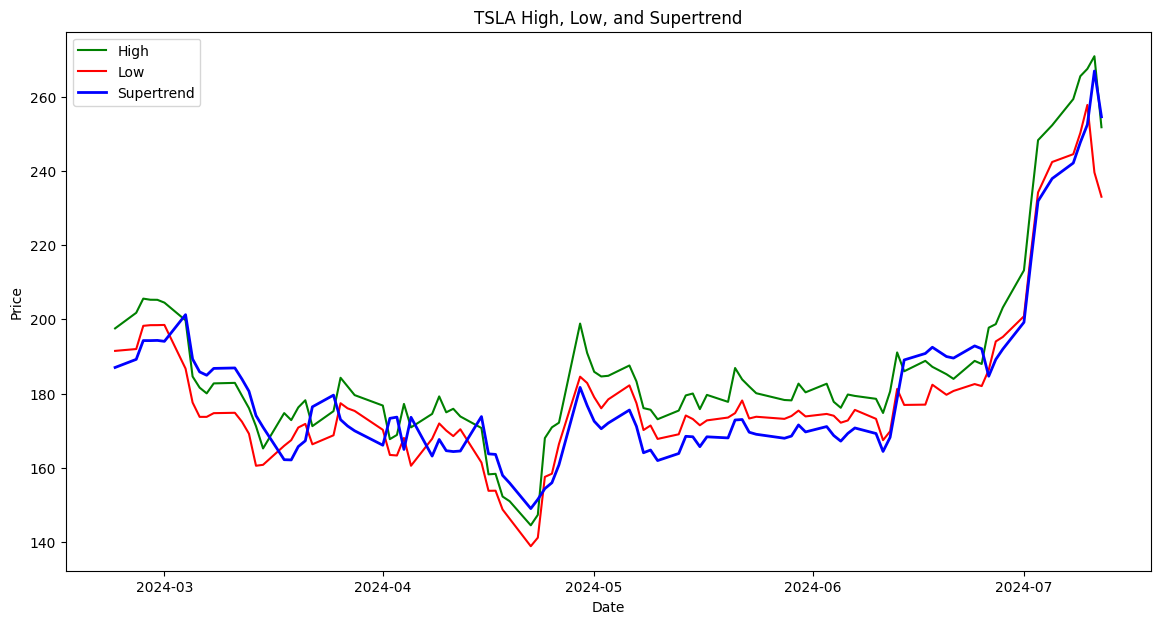

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df_with_supertrend.index, df_with_supertrend['High'], label='High', color='green')
plt.plot(df_with_supertrend.index, df_with_supertrend['Low'], label='Low', color='red')
plt.plot(df_with_supertrend.index, df['Supertrend'], label='Supertrend', color='blue', linewidth=2)
# plt.plot(df.index, df['Upper Band'], label='Upper Band', color='black', linewidth=2)
# plt.plot(df.index, df['Lower Band'], label='Lower Band', color='black', linewidth=2)

# Add titles and labels
plt.title(f'{symbol} High, Low, and Supertrend')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

## Function to generate buy sell signals using Supertrend for Candle Stick Graph

In [ ]:
#the final function to check if a stock a good to buy or not based on supertrend analysis until the last date before given present date
def shouldBuy(name, period, multiplier) : #provide name of stock, period and multiplier as input
  start_date = (datetime.now() - relativedelta(months=6)).date()
  end_date = datetime.now().date()
  df_final = yf.download(name, start=start_date, end=end_date)
  df_final = df[['Open', 'High', 'Low', 'Close']]
  df_final = calculate_supertrend(df_final,period,multiplier)
  if df_final['Supertrend'].iloc[-1] == df_final['Lower Band'].iloc[-1] :
    return True
  else:
    return False

In [ ]:
if shouldBuy("TSLA",14,1) :
  print("## :- " +  "Yes")
else :
  print("## :- " +  "No")

[*********************100%%**********************]  1 of 1 completed

## :- No


# Function to plot RSI Indicator (to be used along with supertrend indicator)

In [ ]:
def calculate_rsi(df, period=14):

    df2 = df.copy()
    if period > len(df):
        print("data too short for analysis")
        return df

    df2['Change'] = df2['Close'].diff()
    df2['Gain'] = np.where(df2['Change'] > 0, df2['Change'], 0)
    df2['Loss'] = np.where(df2['Change'] < 0, -df2['Change'], 0)

    df2['Avg Gain'] = np.nan
    df2['Avg Loss'] = np.nan

    df2.iloc[period, df2.columns.get_loc('Avg Gain')] = df2['Gain'].iloc[1:period + 1].mean()
    df2.iloc[period, df2.columns.get_loc('Avg Loss')] = df2['Loss'].iloc[1:period + 1].mean()

    for i in range(period + 1, len(df)):
        df2.iloc[i, df2.columns.get_loc('Avg Gain')] = (df2.iloc[i-1, df2.columns.get_loc('Avg Gain')] * (period - 1) + df2.iloc[i, df2.columns.get_loc('Gain')]) / period
        df2.iloc[i, df2.columns.get_loc('Avg Loss')] = (df2.iloc[i-1, df2.columns.get_loc('Avg Loss')] * (period - 1) + df2.iloc[i, df2.columns.get_loc('Loss')]) / period

    df2['RS'] = df2['Avg Gain'] / df2['Avg Loss']
    df2['RSI'] = 100 - (100 / (1 + df2['RS']))

    df2.drop(columns=['Change', 'Gain', 'Loss', 'Avg Gain', 'Avg Loss', 'RS'], inplace=True)
    df2.dropna(subset=['RSI'], inplace=True)

    return df2

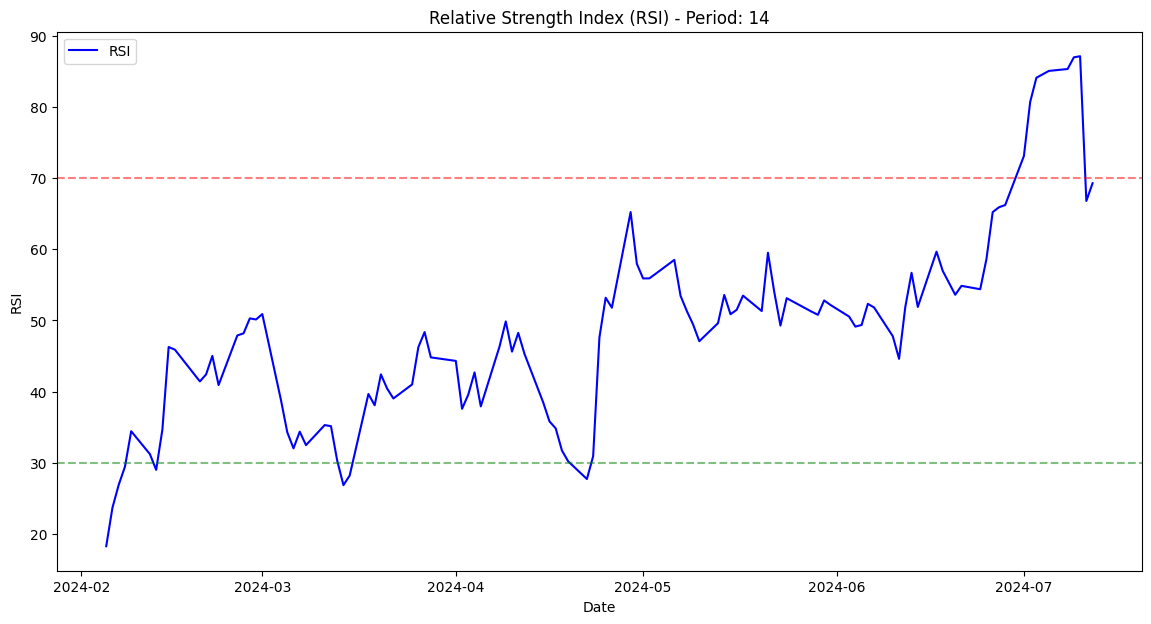

In [ ]:
import matplotlib.pyplot as plt

def plot_rsi(df, period=14):
    # Calculate RSI
    df_with_rsi = calculate_rsi(df, period)

    # Plot RSI
    plt.figure(figsize=(14, 7))
    plt.plot(df_with_rsi.index, df_with_rsi['RSI'], label='RSI', color='blue')

    # Draw horizontal lines at 70% and 30%
    plt.axhline(70, linestyle='--', alpha=0.5, color='red')
    plt.axhline(30, linestyle='--', alpha=0.5, color='green')

    # Add labels and title
    plt.title(f'Relative Strength Index (RSI) - Period: {period}')
    plt.xlabel('Date')
    plt.ylabel('RSI')
    plt.legend()

    plt.show()

# Assuming df is your DataFrame containing HLOC values
plot_rsi(df)

# Function to plot Heikin Ashi Graph and Supertrend Indicator for it

In [ ]:
def calculate_heikin_ashi(df):
    heikin_ashi_df = df.copy()

    heikin_ashi_df['HA_Close'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4
    heikin_ashi_df['HA_Open'] = (df['Open'].shift(1) + df['Close'].shift(1)) / 2
    # Use .iloc to access the first row by position regardless of index type
    heikin_ashi_df.iloc[0, heikin_ashi_df.columns.get_loc('HA_Open')] = (df.iloc[0]['Open'] + df.iloc[0]['Close']) / 2
    heikin_ashi_df['HA_High'] = heikin_ashi_df[['HA_Open', 'HA_Close', 'High']].max(axis=1)
    heikin_ashi_df['HA_Low'] = heikin_ashi_df[['HA_Open', 'HA_Close', 'Low']].min(axis=1)

    return heikin_ashi_df

def calculate_supertrend_heikin_ashi(df, period=14, multiplier=1):
    heikin_ashi_df = calculate_heikin_ashi(df)

    if period > len(heikin_ashi_df):
        print("data too short for analysis")
        return heikin_ashi_df

    heikin_ashi_df['TR'] = np.nan

    heikin_ashi_df.iloc[0, heikin_ashi_df.columns.get_loc('TR')] = heikin_ashi_df.iloc[0, heikin_ashi_df.columns.get_loc('HA_High')] - heikin_ashi_df.iloc[0, heikin_ashi_df.columns.get_loc('HA_Low')]
    for i in range(1, len(heikin_ashi_df)):
        high_low = heikin_ashi_df.iloc[i, heikin_ashi_df.columns.get_loc('HA_High')] - heikin_ashi_df.iloc[i, heikin_ashi_df.columns.get_loc('HA_Low')]
        high_close_prev = abs(heikin_ashi_df.iloc[i, heikin_ashi_df.columns.get_loc('HA_High')] - heikin_ashi_df.iloc[i-1, heikin_ashi_df.columns.get_loc('HA_Close')])
        low_close_prev = abs(heikin_ashi_df.iloc[i, heikin_ashi_df.columns.get_loc('HA_Low')] - heikin_ashi_df.iloc[i-1, heikin_ashi_df.columns.get_loc('HA_Close')])
        heikin_ashi_df.iloc[i, heikin_ashi_df.columns.get_loc('TR')] = max(high_low, high_close_prev, low_close_prev)

    heikin_ashi_df['ATR'] = np.nan

    heikin_ashi_df.iloc[period-1, heikin_ashi_df.columns.get_loc('ATR')] = heikin_ashi_df.iloc[:period, heikin_ashi_df.columns.get_loc('TR')].mean()
    for i in range(period, len(heikin_ashi_df)):
        heikin_ashi_df.iloc[i, heikin_ashi_df.columns.get_loc('ATR')] = ((heikin_ashi_df.iloc[i-1, heikin_ashi_df.columns.get_loc('ATR')] * (period - 1)) + heikin_ashi_df.iloc[i, heikin_ashi_df.columns.get_loc('TR')]) / period

    heikin_ashi_df['Upper Band'] = np.nan
    heikin_ashi_df['Lower Band'] = np.nan
    heikin_ashi_df['Supertrend'] = np.nan
    hl2 = (heikin_ashi_df['HA_High'] + heikin_ashi_df['HA_Low']) / 2
    heikin_ashi_df['Upper Band'] = hl2 + (multiplier * heikin_ashi_df['ATR'])
    heikin_ashi_df['Lower Band'] = hl2 - (multiplier * heikin_ashi_df['ATR'])

    lower = True
    for i in range(period-1, len(heikin_ashi_df)):
        if lower:
            heikin_ashi_df.iloc[i, heikin_ashi_df.columns.get_loc('Supertrend')] = heikin_ashi_df.iloc[i, heikin_ashi_df.columns.get_loc('Lower Band')]
            if i < len(heikin_ashi_df)-1 and min(heikin_ashi_df.iloc[i+1, heikin_ashi_df.columns.get_loc('HA_Close')], heikin_ashi_df.iloc[i+1, heikin_ashi_df.columns.get_loc('HA_Open')]) <= heikin_ashi_df.iloc[i, heikin_ashi_df.columns.get_loc('Lower Band')]:
                lower = False
        else:
            heikin_ashi_df.iloc[i, heikin_ashi_df.columns.get_loc('Supertrend')] = heikin_ashi_df.iloc[i, heikin_ashi_df.columns.get_loc('Upper Band')]
            if i < len(heikin_ashi_df)-1 and max(heikin_ashi_df.iloc[i+1, heikin_ashi_df.columns.get_loc('HA_High')], heikin_ashi_df.iloc[i+1, heikin_ashi_df.columns.get_loc('HA_Close')]) >= heikin_ashi_df.iloc[i, heikin_ashi_df.columns.get_loc('Upper Band')]:
                lower = True

    heikin_ashi_df.dropna(subset=['Supertrend'], inplace=True)

    return heikin_ashi_df

In [ ]:
df_with_supertrend_HA = calculate_supertrend_heikin_ashi(df)

# Create the candlestick chart
fig = go.Figure(data=[go.Candlestick(x=df_with_supertrend.index,
                                     open=df_with_supertrend_HA['HA_Open'],
                                     high=df_with_supertrend_HA['HA_High'],
                                     low=df_with_supertrend_HA['HA_Low'],
                                     close=df_with_supertrend_HA['HA_Close'])])

# Add Supertrend
fig.add_trace(go.Scatter(x=df_with_supertrend_HA.index, y=df_with_supertrend_HA['Supertrend'], mode='lines', name='Supertrend'))

# Add titles and labels
fig.update_layout(title=f'{symbol} Candlestick Chart with Supertrend',
                  xaxis_title='Date',
                  yaxis_title='Price')

# Display the plot
fig.show()

# Function to plot bollinger bands

In [ ]:
def calculate_bollinger_bands(df, period=20, multiplier=2):
    df2 = df.copy()

    if period > len(df):
        print("data too short for analysis")
        return df

    df2['SMA'] = df2['Close'].rolling(window=period).mean()
    df2['STD'] = df2['Close'].rolling(window=period).std()

    df2['Upper Band'] = df2['SMA'] + (multiplier * df2['STD'])
    df2['Lower Band'] = df2['SMA'] - (multiplier * df2['STD'])

    df2.dropna(subset=['SMA', 'Upper Band', 'Lower Band'], inplace=True)

    return df2

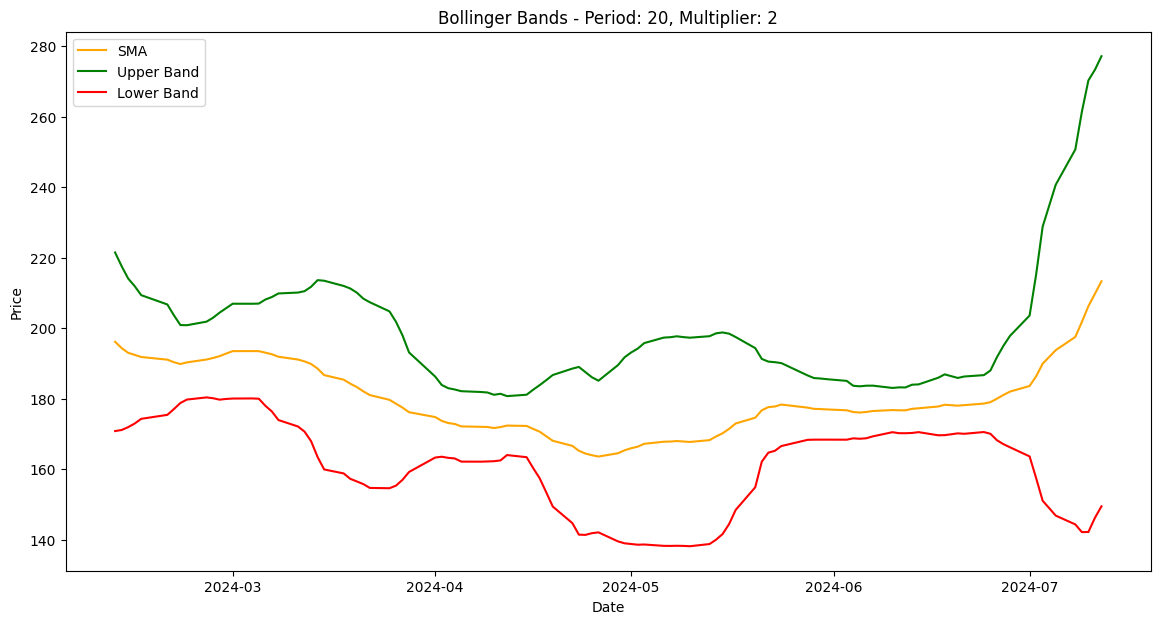

In [ ]:
def plot_bollinger_bands(df, period=20, multiplier=2):
    # Calculate Bollinger Bands
    df_with_bollinger_bands = calculate_bollinger_bands(df, period, multiplier)

    # Plot Close Price and Bollinger Bands
    plt.figure(figsize=(14, 7))
    # plt.plot(df_with_bollinger_bands.index, df_with_bollinger_bands['Close'], label='Close Price', color='blue')
    plt.plot(df_with_bollinger_bands.index, df_with_bollinger_bands['SMA'], label='SMA', color='orange')
    plt.plot(df_with_bollinger_bands.index, df_with_bollinger_bands['Upper Band'], label='Upper Band', color='green')
    plt.plot(df_with_bollinger_bands.index, df_with_bollinger_bands['Lower Band'], label='Lower Band', color='red')

    # Add labels and title
    plt.title(f'Bollinger Bands - Period: {period}, Multiplier: {multiplier}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()

    plt.show()

# Assuming df is your DataFrame containing HLOC values
plot_bollinger_bands(df)

# Final Function to suggest stock using Supertrend for Heikin Ashi, RSI and Bollinger Bands

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
!pip install python-dateutil
from datetime import datetime
from dateutil.relativedelta import relativedelta
import numpy as np
import pandas as pd
import plotly.graph_objects as go

In [3]:
def compute(df,period_rsi,period_supertrend,period_bollinger,multiplier_supertrend,multiplier_bollinger) :
    #rsi calculation
    df2 = df.copy()
    if period_rsi > len(df):
        print("data too short for analysis")
        return df

    df2['Change'] = df2['Close'].diff()
    df2['Gain'] = np.where(df2['Change'] > 0, df2['Change'], 0)
    df2['Loss'] = np.where(df2['Change'] < 0, -df2['Change'], 0)

    df2['Avg Gain'] = np.nan
    df2['Avg Loss'] = np.nan

    df2.iloc[period_rsi, df2.columns.get_loc('Avg Gain')] = df2['Gain'].iloc[1:period_rsi + 1].mean()
    df2.iloc[period_rsi, df2.columns.get_loc('Avg Loss')] = df2['Loss'].iloc[1:period_rsi + 1].mean()

    for i in range(period_rsi + 1, len(df)):
        df2.iloc[i, df2.columns.get_loc('Avg Gain')] = (df2.iloc[i-1, df2.columns.get_loc('Avg Gain')] * (period_rsi - 1) + df2.iloc[i, df2.columns.get_loc('Gain')]) / period_rsi
        df2.iloc[i, df2.columns.get_loc('Avg Loss')] = (df2.iloc[i-1, df2.columns.get_loc('Avg Loss')] * (period_rsi - 1) + df2.iloc[i, df2.columns.get_loc('Loss')]) / period_rsi

    df2['RS'] = df2['Avg Gain'] / df2['Avg Loss']
    df2['RSI'] = 100 - (100 / (1 + df2['RS']))

    df2.drop(columns=['Change', 'Gain', 'Loss', 'Avg Gain', 'Avg Loss', 'RS'], inplace=True)

    #supertrend caculation
    df2['HA_Close'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4
    df2['HA_Open'] = (df['Open'].shift(1) + df['Close'].shift(1)) / 2
    df2.iloc[0, df2.columns.get_loc('HA_Open')] = (df.iloc[0]['Open'] + df.iloc[0]['Close']) / 2
    df2['HA_High'] = df2[['HA_Open', 'HA_Close', 'High']].max(axis=1)
    df2['HA_Low'] = df2[['HA_Open', 'HA_Close', 'Low']].min(axis=1)

    if period_supertrend > len(df2):
        print("data too short for analysis")
        return df2

    df2['TR'] = np.nan

    df2.iloc[0, df2.columns.get_loc('TR')] = df2.iloc[0, df2.columns.get_loc('HA_High')] - df2.iloc[0, df2.columns.get_loc('HA_Low')]
    for i in range(1, len(df2)):
        high_low = df2.iloc[i, df2.columns.get_loc('HA_High')] - df2.iloc[i, df2.columns.get_loc('HA_Low')]
        high_close_prev = abs(df2.iloc[i, df2.columns.get_loc('HA_High')] - df2.iloc[i-1, df2.columns.get_loc('HA_Close')])
        low_close_prev = abs(df2.iloc[i, df2.columns.get_loc('HA_Low')] - df2.iloc[i-1, df2.columns.get_loc('HA_Close')])
        df2.iloc[i, df2.columns.get_loc('TR')] = max(high_low, high_close_prev, low_close_prev)

    df2['ATR'] = np.nan

    df2.iloc[period_supertrend-1, df2.columns.get_loc('ATR')] = df2.iloc[:period_supertrend, df2.columns.get_loc('TR')].mean()
    for i in range(period_supertrend, len(df2)):
        df2.iloc[i, df2.columns.get_loc('ATR')] = ((df2.iloc[i-1, df2.columns.get_loc('ATR')] * (period_supertrend - 1)) + df2.iloc[i, df2.columns.get_loc('TR')]) / period_supertrend

    df2['Upper Band'] = np.nan
    df2['Lower Band'] = np.nan
    df2['Supertrend'] = np.nan
    hl2 = (df2['HA_High'] + df2['HA_Low']) / 2
    df2['Upper Band'] = hl2 + (multiplier_supertrend * df2['ATR'])
    df2['Lower Band'] = hl2 - (multiplier_supertrend * df2['ATR'])

    lower = True
    for i in range(period_supertrend-1, len(df2)):
        if lower:
            df2.iloc[i, df2.columns.get_loc('Supertrend')] = df2.iloc[i, df2.columns.get_loc('Lower Band')]
            if i < len(df2)-1 and min(df2.iloc[i+1, df2.columns.get_loc('HA_Close')], df2.iloc[i+1, df2.columns.get_loc('HA_Open')]) <= df2.iloc[i, df2.columns.get_loc('Lower Band')]:
                lower = False
        else:
           df2.iloc[i, df2.columns.get_loc('Supertrend')] = df2.iloc[i, df2.columns.get_loc('Upper Band')]
           if i < len(df2)-1 and max(df2.iloc[i+1, df2.columns.get_loc('HA_High')], df2.iloc[i+1, df2.columns.get_loc('HA_Close')]) >= df2.iloc[i, df2.columns.get_loc('Upper Band')]:
                lower = True
    df2.drop(columns=['TR'], inplace=True)

    #bollinger bands calculatiion

    if period_bollinger > len(df):
        print("data too short for analysis")
        return df

    df2['SMA'] = df2['Close'].rolling(window=period_bollinger).mean()
    df2['STD'] = df2['Close'].rolling(window=period_bollinger).std()

    df2['Upper Band Bollinger'] = df2['SMA'] + (multiplier_bollinger * df2['STD'])
    df2['Lower Band Bollinger'] = df2['SMA'] - (multiplier_bollinger * df2['STD'])

    df2.dropna(subset=['SMA', 'Upper Band Bollinger', 'Lower Band Bollinger'], inplace=True)
    df2.dropna(subset=['Supertrend'], inplace=True)
    df2.dropna(subset=['RSI'], inplace=True)

    return df2

In [7]:
df_f = compute(df,14,14,20,1,2)
df_f.head()

,Open,High,Low,Close,RSI,HA_Close,HA_Open,HA_High,HA_Low,ATR,Upper Band,Lower Band,Supertrend,SMA,STD,Upper Band Bollinger,Lower Band Bollinger
Date,,,,,,,,,,,,,,,,,
2024-02-16,202.059998,203.169998,197.399994,199.949997,47.404533,200.644997,194.805000,203.169998,194.805000,9.068694,208.056193,189.918806,189.918806,191.818001,8.765137,209.348275,174.287726
2024-02-20,196.130005,198.600006,189.130005,193.759995,43.030273,194.405003,201.004997,201.004997,189.130005,9.269143,204.336645,185.798358,185.798358,191.066000,7.826399,206.718798,175.413203
2024-02-21,193.360001,199.440002,191.949997,194.770004,43.939271,194.880001,194.945000,199.440002,191.949997,9.142062,204.837062,186.552938,186.552938,190.347501,6.651170,203.649841,177.045161
2024-02-22,194.000000,198.320007,191.360001,197.410004,46.348954,195.272503,194.065002,198.320007,191.360001,8.986201,203.826205,185.853803,185.853803,189.826501,5.521896,200.870293,178.782708
2024-02-23,195.309998,197.570007,191.500000,191.970001,42.312926,194.087502,195.705002,197.570007,191.500000,8.777902,203.312905,185.757102,185.757102,190.293501,5.270467,200.834435,179.752566


In [8]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.subplots as sp

def plot_combined_chart(df):
    # Create subplots
    fig = sp.make_subplots(rows=3, cols=1, shared_xaxes=True,
                           vertical_spacing=0.03,
                           subplot_titles=('Heikin Ashi Candlestick Chart with SuperTrend', 'Bollinger Bands', 'RSI'),
                           row_heights=[0.5, 0.3, 0.2])

    # Heikin Ashi Candlestick Chart
    fig.add_trace(go.Candlestick(x=df.index,
                                 open=df['HA_Open'],
                                 high=df['HA_High'],
                                 low=df['HA_Low'],
                                 close=df['HA_Close'],
                                 name='Heikin Ashi Candlestick'),
                  row=1, col=1)

    # Add Supertrend
    fig.add_trace(go.Scatter(x=df.index, y=df['Supertrend'], line=dict(color='blue', width=1), name='Supertrend'), row=1, col=1)

    # Bollinger Bands
    fig.add_trace(go.Scatter(x=df.index, y=df['Close'], line=dict(color='black', width=1), name='Close Price'), row=2, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=df['Upper Band Bollinger'], line=dict(color='blue', width=1), name='Upper Bollinger Band'), row=2, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=df['Lower Band Bollinger'], line=dict(color='red', width=1), name='Lower Bollinger Band'), row=2, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=df['SMA'], line=dict(color='green', width=1), name='SMA'), row=2, col=1)

    # RSI
    fig.add_trace(go.Scatter(x=df.index, y=df['RSI'], line=dict(color='purple', width=1), name='RSI'), row=3, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=[70] * len(df), line=dict(color='red', dash='dash'), name='70'), row=3, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=[30] * len(df), line=dict(color='green', dash='dash'), name='30'), row=3, col=1)

    # Update layout
    fig.update_layout(title='Heikin Ashi Candlestick, Bollinger Bands, and RSI',
                      yaxis_title='Price',
                      xaxis_title='Date',
                      xaxis_rangeslider_visible=False,
                      template='plotly_dark',
                      height=900)

    fig.show()

plot_combined_chart(df_f)


In [9]:
def stock_suggest(name):
    start_date = (datetime.now() - relativedelta(months=6)).date()
    end_date = datetime.now().date()
    df = yf.download(name, start=start_date, end=end_date)
    df_final = df[['Open', 'High', 'Low', 'Close']]
    df_final = compute(df_final, 14, 14, 20, 1, 2)

    #plot graphs
    plot_combined_chart(df_final)

    last_row = df_final.iloc[-1]

    # Supertrend Signal
    supertrend_signal = last_row['Close'] > last_row['Supertrend']

    # RSI Signal
    rsi_signal = last_row['RSI'] < 30

    # Bollinger Bands Signal
    bollinger_signal = last_row['Close'] < last_row['Lower Band Bollinger']

    # Combining Signals
    buy_signals = sum([supertrend_signal, rsi_signal, bollinger_signal])
    sell_signals = sum([not supertrend_signal, last_row['RSI'] > 70, last_row['Close'] > last_row['Upper Band Bollinger']])

    if buy_signals > sell_signals:
        recommendation = "Buy"
    elif sell_signals > buy_signals:
        recommendation = "Sell"
    else:
        recommendation = "Hold"

    print(f"Stock: {name}")
    print(f"Supertrend Signal: {'Buy' if supertrend_signal else 'Sell'}")
    print(f"RSI Signal: {'Buy' if rsi_signal else 'Sell' if last_row['RSI'] > 70 else 'Hold'}")
    print(f"Bollinger Bands Signal: {'Buy' if bollinger_signal else 'Sell' if last_row['Close'] > last_row['Upper Band Bollinger'] else 'Hold'}")
    print(f"Recommendation: {recommendation}")

    return recommendation

In [ ]:
stock_suggest("TSLA")

[*********************100%%**********************]  1 of 1 completed


Stock: TSLA
Supertrend Signal: Sell
RSI Signal: Hold
Bollinger Bands Signal: Hold
Recommendation: Sell


'Sell'

In [ ]:
stock_suggest("NVDA")

[*********************100%%**********************]  1 of 1 completed


Stock: NVDA
Supertrend Signal: Buy
RSI Signal: Hold
Bollinger Bands Signal: Hold
Recommendation: Buy


'Buy'